# Tutorial: Simple Maze Environment
In this notebook, a simple maze environment is set up and solved.

# Importing Dependencies
<strong>We will begin with importing the dependencies</strong>

In [1]:
# Importing Libraries
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

# Maze Environment

<strong>Let's introduce the type of maze we intend to solve here,</strong> 
<small>[[source](https://www.davidsilver.uk/teaching/)]</small>

<br>

```{figure} Images/rl_Maze.png
---
width: 80%
align: center
name: rl_maze
---
A sample maze
```

<strong>

Now, there are multiple ways to structure the information within this environment.

If used as an <i>image</i>, it can be solved using a 'CNN policy' and such a setting would allow a fully observed state to our agent for taking action. To achieve this, we would need to implement <i>Wrappers</i>, or maybe stack the states to give agent information about motion.

However, a much simpler case is to use a boolean mask to denote path and walls, allowing the agent to make decisions based on the conditions of immediate neighbours. Such a setting is a partially observed MDP, and may most possibly yield a near-optimal policy. This approach can be tackled using a 'MLP policy', but for such a small search space it's feasible to start with Q-learning.

</strong>

In [43]:
# Simple Maze setting
# 0 -> Walls
# 1 -> Path
Maze = np.array([
        [0,0,0,0,0,0,0,0],
        [0,1,1,1,1,1,1,0],
        [1,1,0,0,1,0,1,0],
        [0,1,1,0,0,1,1,0],
        [0,0,1,1,0,1,0,0],
        [0,1,0,1,0,1,1,0],
        [0,1,1,1,1,0,1,1],
        [0,0,0,0,0,0,0,0]
        ])
#Maze = pd.DataFrame(Maze)
print(Maze[2,0]) # Start position
Maze


1


array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Encoding Maze Position to State for easier discritization
Maze_ind = np.arange(64).reshape(8,8)
np.where(Maze_ind == 16)[1][0]

In [2]:
# Making the Maze Environment
class MazeEnv(Env):
    def __init__(self):
        self.action_space = Discrete(4)
        self.observation_space = Discrete(64)
        self.Maze = np.array([
            [0,0,0,0,0,0,0,0],
            [0,1,1,1,1,1,1,0],
            [1,1,0,0,1,0,1,0],
            [0,1,1,0,0,1,1,0],
            [0,0,1,1,0,1,0,0],
            [0,1,0,1,0,1,1,0],
            [0,1,1,1,1,0,1,1],
            [0,0,0,0,0,0,0,0]
            ])
        self.mouse = [2,0]
        self.cheese = [6,7]
        self.state = int(np.arange(64).reshape(8,8)[self.mouse[0], self.mouse[1]])
        self.step_counter = 27
        
    def step(self, action):
        # action-> 0: Up, 1: Down, 2: Left, 3: Right
        if action == 0:
            new_coor = [self.mouse[0]-1, self.mouse[1]]
        elif action == 1:
            new_coor = [self.mouse[0]+1, self.mouse[1]]
        elif action == 2:
            new_coor = [self.mouse[0], self.mouse[1]-1]
        elif action == 3:
            new_coor = [self.mouse[0], self.mouse[1]+1]
        reward = -10
        if (new_coor[0] != -1) and (new_coor[1] != -1):
            if self.Maze[new_coor[0],new_coor[1]] == 1:
                self.mouse = new_coor
                self.state = int(np.arange(64).reshape(8,8)[self.mouse[0], self.mouse[1]])
                reward = -1
            elif new_coor == 0:
                reward = -10
        else:
            reward = -10
        if self.mouse == self.cheese:
            done = True
            reward += 100
        else:
            done = False
        self.step_counter -= 1
        if self.step_counter == 0:
            done = True
            reward -= 100
        info = {}
        return self.state, reward, done, info

    def render(self, mode = None):
        Maze = np.array(self.Maze)
        print(self.mouse, self.cheese)
        Maze[self.mouse[0],self.mouse[1]] = 2
        Maze[self.cheese[0],self.cheese[1]] = 3
        print(Maze)
    
    def reset(self):
        self.Maze = np.array([
            [0,0,0,0,0,0,0,0],
            [0,1,1,1,1,1,1,0],
            [1,1,0,0,1,0,1,0],
            [0,1,1,0,0,1,1,0],
            [0,0,1,1,0,1,0,0],
            [0,1,0,1,0,1,1,0],
            [0,1,1,1,1,0,1,1],
            [0,0,0,0,0,0,0,0]
            ])
        self.mouse = [2,0]
        self.state = int(np.arange(64).reshape(8,8)[self.mouse[0], self.mouse[1]])
        self.step_counter = 27
        return self.state

# Checking Environment

In [44]:
# Checking whether our custom environment conforms with the necessary assertions
from stable_baselines3.common.env_checker import check_env
env = MazeEnv()
check_env(env, warn=True)
# Observe the state initialization
env.reset()
env.render()

[2, 0] [6, 7]
[[0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 0]
 [2 1 0 0 1 0 1 0]
 [0 1 1 0 0 1 1 0]
 [0 0 1 1 0 1 0 0]
 [0 1 0 1 0 1 1 0]
 [0 1 1 1 1 0 1 3]
 [0 0 0 0 0 0 0 0]]


In [22]:
# Observe the state/observation and acion spaces
print(env.action_space)
print(env.observation_space)
# Print number of states for Discrete gym spaces
print(env.action_space.n)
print(env.observation_space.n)

Discrete(4)
Discrete(64)
4
64


In [ ]:
# Manually test out the environment, specifically how the state transitions are acting
# action-> 0: Up, 1: Down, 2: Left, 3: Right
state, reward, done, _ = env.step(0)
print(state, reward, done)
env.render()

# Random action episodes

In [45]:
# Perform episodes of random actions, i.e. No decision making
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:-307
Episode:2 Score:-244
Episode:3 Score:-334
Episode:4 Score:-208
Episode:5 Score:-262


# Testing DQN from stable_baselines3

<strong>We can attempt to directly fit a DQN model from stable_baselines. 

Let's see what happens.</strong>

In [19]:
from stable_baselines3 import DQN
model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100000)

In [20]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, env, n_eval_episodes=100, render=False)

C:\Users\sarth\.conda\envs\master\lib\site-packages\stable_baselines3\common\evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


(-127.0, 0.0)

In [21]:
obs = env.reset()
done = False
score = 0 
while not done:
    #env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    score+=reward
print('Score:{}'.format(score))

Score:-127


<strong>

We observe that we are not getting acceptable scores, however that is not a reason to be discouraged.

This points out that finding out the proper algorithm is just as important as making a proper environment for your task.

Since, the manner in which the obervation_space, action_space and agent-environment interction are set, DQN would not be an optimal algorithm choice.
</strong>

# Defining Agent for Q-Learning

In [3]:
# Defining the Agent
class Agent():
    def __init__ (self, lr, gamma, n_actions, n_states, eps_start, eps_end, eps_dec):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.epsilon = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec

        self.Q = {}

        self.init_Q()

    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q[(state, action)] = 0.0
                
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice([i for i in range(self.n_actions)])
        else:
            actions = np.array([self.Q[(state, a)] for a in range(self.n_actions)])
            action = np.argmax(actions)
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon*self.eps_dec if self.epsilon > self.eps_min else self.eps_min
    
    def learn(self, state, action, reward, state_):
        actions = np.array([self.Q[(state_, a)] for a in range(self.n_actions)])
        a_max = np.argmax(actions)

        self.Q[(state, action)] += self.lr * (reward + self.gamma * self.Q[(state_, a_max)] - self.Q[(state, action)])
        self.decrement_epsilon()

# A simple Plotting code

In [4]:
# A simple plot
def plot_learning_curve(x, scores, epsilons):
    fig = plt.figure()
    ax = fig.add_subplot(111, label = "1")
    ax2 = fig.add_subplot(111, label = "2", frame_on = False)

    ax.plot(x, epsilons, color = "C0")
    ax.set_xlabel("Training Steps", color = "C0")
    ax.set_ylabel("Epsilon", color = "C0")
    ax.tick_params(axis = 'x', colors = "C0")
    ax.tick_params(axis = 'y', colors = "C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color = "C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color = "C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis = 'y', colors = "C1")

# Main Execution code

Episode:10000 Score:-226
Episode:20000 Score:-181
Episode:30000 Score:-226
Episode:40000 Score:-181
Episode:50000 Score:3
Episode:60000 Score:53
Episode:70000 Score:53
Episode:80000 Score:-172
Episode:90000 Score:-81
Episode:100000 Score:71
Best Score: 85


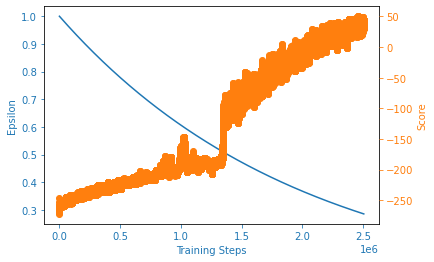

In [5]:
# Execution code for training the Agent
env = MazeEnv()
agent = Agent(
    lr = 0.001, 
    gamma = 0.9, 
    eps_start = 1.0, 
    eps_end = 0.01, 
    eps_dec = 0.9999995, 
    n_actions = env.action_space.n, 
    n_states = env.observation_space.n
    )
best_score = -np.inf
episodes = 100000
n_steps = 0
scores, eps_history, steps_array = [], [], []
for episode in range(1, episodes+1):
    observation = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.learn(observation, action, reward, observation_)
        score += reward
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)
    eps_history.append(agent.epsilon)
    if episode % 10000 == 0:
        print('Episode:{} Score:{}'.format(episode, score))

    if score > best_score:
        best_score = score
#print(scores)
plot_learning_curve(steps_array, scores, eps_history)
print('Best Score: {}'.format(best_score))

# Testing Agent performance

<strong>
We can run the Testing code below multiple times.
</strong>

In [42]:
# Testing the Agent 
SHOW_INDIVIDUAL_EPISODE = False
seq_episodes = [1,5,10,15,20, 50, 100, 1000]
for episodes in seq_episodes:
    scores, len_eps = [], []
    for episode in range(1,episodes+1):
        observation = env.reset()
        done = False
        score = 0 
        #env.render()
        len_cnt = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            #agent.learn(observation, action, reward, observation_)
            score += reward
            observation = observation_
            #env.render()
            len_cnt += 1
        scores.append(score)
        len_eps.append(len_cnt)
        if SHOW_INDIVIDUAL_EPISODE:
            print('Episode {}: Len_Episode = {}, Score = {}'.format(episode, len_cnt, score))
    print('\nFinal (Num_episodes = {}): Avg_Len_Episode = {}, Avg_Score = {}'.format(episodes, np.mean(len_eps), np.mean(scores)))


Final (Num_episodes = 1): Avg_Len_Episode = 21.0, Avg_Score = 43.0

Final (Num_episodes = 5): Avg_Len_Episode = 21.4, Avg_Score = 49.8

Final (Num_episodes = 10): Avg_Len_Episode = 20.1, Avg_Score = 47.4

Final (Num_episodes = 15): Avg_Len_Episode = 19.6, Avg_Score = 53.4

Final (Num_episodes = 20): Avg_Len_Episode = 20.35, Avg_Score = 59.4

Final (Num_episodes = 50): Avg_Len_Episode = 20.92, Avg_Score = 45.7

Final (Num_episodes = 100): Avg_Len_Episode = 20.81, Avg_Score = 39.36

Final (Num_episodes = 1000): Avg_Len_Episode = 20.915, Avg_Score = 35.86


<strong>

The average length of the episode and score vary significantly. 

This highlights the instability in RL agents. 

This is inevitable since we are working with POMDP and learning a stochastic policy.
</strong>

In [ ]:
# You can inspect the Q values that guide the decision making.
Q_values = pd.DataFrame(np.array(list(agent.Q.values())).reshape(64,4))
print(Q_values)

<strong>
There are ways using which the above performance can be improved. I'll list some of them as a personal exercise,

1. Tweek around with the <i>Reward Function</i>.
2. Using other exploration policies.
3. Learning deterministic policy, or simply applying polcy-based methods.
4. Improving the state representations, for example making it fully observable.
5. Vectorizing environment.

</strong>